In [1]:
import gym
import pylab
import numpy as np

In [12]:
def get_reward(feature_matrix, theta, n_states, state_idx):
    irl_rewards = feature_matrix.dot(theta).reshape((n_states,))
    return irl_rewards[state_idx]

def expert_feature_expectations(feature_matrix, demonstrations):
    feature_expectations = np.zeros(feature_matrix.shape[0])
    
    for demonstration in demonstrations:
        for state_idx, _, _ in demonstration:
            feature_expectations += feature_matrix[int(state_idx)]

    feature_expectations /= demonstrations.shape[0]
    return feature_expectations

def maxent_irl(expert, learner, theta, learning_rate):
    gradient = expert - learner
    theta += learning_rate * gradient

    # Clip theta
    for j in range(len(theta)):
        if theta[j] > 0:
            theta[j] = 0

def idx_demo(env, one_feature):
    env_low = env.observation_space.low     
    env_high = env.observation_space.high   
    env_distance = (env_high - env_low) / one_feature  

    raw_demo = np.load(file='Data/expert_demo.npy')
    demonstrations = np.zeros((len(raw_demo), len(raw_demo[0]), 3))

    for x in range(len(raw_demo)):
        for y in range(len(raw_demo[0])):
            position_idx = int((raw_demo[x][y][0] - env_low[0]) / env_distance[0])
            velocity_idx = int((raw_demo[x][y][1] - env_low[1]) / env_distance[1])
            state_idx = position_idx + velocity_idx * one_feature

            demonstrations[x][y][0] = state_idx
            demonstrations[x][y][1] = raw_demo[x][y][2] 
            
    return demonstrations

def idx_state(env, state):
    env_low = env.observation_space.low
    env_high = env.observation_space.high 
    env_distance = (env_high - env_low) / one_feature 
    position_idx = int((state[0] - env_low[0]) / env_distance[0])
    velocity_idx = int((state[1] - env_low[1]) / env_distance[1])
    state_idx = position_idx + velocity_idx * one_feature
    return state_idx

def update_q_table(state, action, reward, next_state):
    q_1 = q_table[state][action]
    q_2 = reward + gamma * max(q_table[next_state])
    q_table[state][action] += q_learning_rate * (q_2 - q_1)

In [13]:
n_states = 400 # position - 20, velocity - 20
n_actions = 3
one_feature = 20 # number of state per one feature
q_table = np.zeros((n_states, n_actions)) # (400, 3)
feature_matrix = np.eye((n_states)) # (400, 400)

gamma = 0.99
q_learning_rate = 0.03
theta_learning_rate = 0.05

np.random.seed(1)

0 episode score is -200.00
1000 episode score is -200.00
2000 episode score is -199.27
3000 episode score is -196.50


KeyboardInterrupt: 

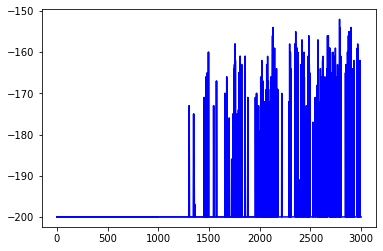

In [14]:
env = gym.make('MountainCar-v0')
demonstrations = idx_demo(env, one_feature)

expert = expert_feature_expectations(feature_matrix, demonstrations)
learner_feature_expectations = np.zeros(n_states)

theta = -(np.random.uniform(size=(n_states,)))

episodes, scores = [], []

for episode in range(30000):
    state = env.reset()
    score = 0

    if (episode != 0 and episode == 10000) or (episode > 10000 and episode % 5000 == 0):
        learner = learner_feature_expectations / episode
        maxent_irl(expert, learner, theta, theta_learning_rate)

    while True:
        state_idx = idx_state(env, state)
        action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)

        irl_reward = get_reward(feature_matrix, theta, n_states, state_idx)
        next_state_idx = idx_state(env, next_state)
        update_q_table(state_idx, action, irl_reward, next_state_idx)

        learner_feature_expectations += feature_matrix[int(state_idx)]

        score += reward
        state = next_state

        if done:
            scores.append(score)
            episodes.append(episode)
            break

    if episode % 1000 == 0:
        score_avg = np.mean(scores)
        print('{} episode score is {:.2f}'.format(episode, score_avg))
        pylab.plot(episodes, scores, 'b')
        pylab.savefig("Data/maxent0_30000.png")
        np.save("Data/maxent0_q_table", arr=q_table)